### Imports

In [1]:
from IPython.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import glob
import json
import os
import pickle
import random
import sys
from copy import deepcopy
from typing import Literal, Optional, Union

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import ml_collections
import numpy as np
import torch
from torch.utils.data import Dataset

from careamics.config.likelihood_model import NMLikelihoodConfig
from careamics.config.nm_model import MultiChannelNMConfig
from careamics.lightning import VAEModule
from careamics.lvae_training.eval_utils import (
    Calibration,
    get_calibrated_factor_for_stdev,
    get_dset_predictions,
    get_eval_output_dir,
    plot_calibration,
    plot_error,
    show_for_one,
    stitch_predictions,
)
from careamics.models.lvae.noise_models import noise_model_factory
from careamics.utils.metrics import (
    # avg_psnr,
    # avg_range_inv_psnr,
    # avg_ssim,
    scale_invariant_psnr,
    # multiscale_ssim
)
# TODO: sorry for this :(
sys.path.insert(0, "/home/federico.carrara/Documents/projects/microSplit-reproducibility/")
sys.path.insert(0, "/home/igor.zubarev/projects/microSplit-reproducibility/")

from data import (
    LCMultiChDloader, MultiChDloader, DataSplitType, DataType
)
from data.data_utils import GridAlignement, load_tiff

torch.multiprocessing.set_sharing_strategy('file_system')

ModuleNotFoundError: No module named 'cv2'

In [ ]:
def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

fix_seeds()

In [ ]:
DATA_DIR = '/group/jug/federico/careamics_training/data/BioSR'
OUT_ROOT = '/home/igor.zubarev/data/splits/'
DEBUG = False

In [ ]:
ckpt_dir = os.path.join(OUT_ROOT, '2409/musplit_with_LC/2/')
assert os.path.exists(ckpt_dir)

### Set Evaluation Parameters

In [15]:
# Set eval parameters
mmse_count: int = 10
"""The number of predictions to average for MMSE evaluation."""
image_size_for_grid_centers: int = 32
"""The size of the portion of image we retain from inner padding/tiling."""
eval_patch_size: Optional[int] = 64
"""The actual patch size. If not specified data.image_size."""
psnr_type: Literal['simple', 'range_invariant'] = 'range_invariant'
"""The type of PSNR to compute."""
which_ckpt: Literal['best', 'last'] = 'best'
"""Which checkpoint to use for evaluation."""
enable_calibration: bool = False
"""Whether to enable calibration."""
eval_datasplit_type = DataSplitType.Test
"""The data split used for evaluation."""
batch_size: int = 32
"""Batch size for data loader."""
num_workers = 4
"""Number of workers for data loader."""
use_deterministic_grid = None
"""Whether to use a deterministic grid for evaluation (i.e., get a random patch)."""
data_t_list = None
"""List of indexes of the data to be used (e.g., for debugging or picking a particular image)."""

'List of indexes of the data to be used (e.g., for debugging or picking a particular image).'

### Load config 

In [16]:
def get_model_checkpoint(
    ckpt_dir: str, mode: Literal['best', 'last'] = 'best'
) -> str:
    output = []
    for fpath in glob.glob(ckpt_dir + "/*.ckpt"):
        fname = os.path.basename(fpath)
        if mode == 'best':
            if fname.startswith('best'):
                output.append(fpath)
        elif mode == 'last':
            if fname.startswith('last'):
                output.append(fpath)
    assert len(output) == 1, '\n'.join(output)
    return output[0]

In [17]:
def load_file(file_path: str):
    # Get the file extension
    _, ext = os.path.splitext(file_path)

    # Check the extension and load the file accordingly
    if ext == '.pkl':
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    elif ext == '.json':
        with open(file_path) as f:
            return json.load(f)
    else:
        raise ValueError(f"Unsupported file extension: {ext}. Only .pkl and .json are supported.")

def load_config(config_fpath: str, config_type: Literal['algorithm', 'training', 'data']) -> dict:
    for fname in glob.glob(os.path.join(config_fpath, '*config.*')):
        fname = os.path.basename(fname)
        if fname.startswith(config_type):
            return load_file(os.path.join(config_fpath, fname))
    raise ValueError(f"Config file not found in {config_fpath}.")

In [18]:
if os.path.isdir(ckpt_dir):
    algo_config = load_config(ckpt_dir, "algorithm")
    training_config = load_config(ckpt_dir, "training")
    data_config = load_config(ckpt_dir, "data")

### Load dataset

In [19]:
def create_dataset(
    config: dict,
    datadir: str,
    eval_datasplit_type = DataSplitType.Val,
    skip_train_dataset = False,
    kwargs_dict = None,
) -> tuple[Dataset, Dataset, tuple[float, float]]:
    if kwargs_dict is None:
        kwargs_dict = {}

    datapath = datadir

    # Hard-coded parameters (used to be in the config file)
    normalized_input = True
    use_one_mu_std = True
    train_aug_rotate = False
    enable_random_cropping = True
    lowres_supervision = False

    # 1) Data loader for Lateral Contextualization
    if config.multiscale_lowres_count > 1:
        # Get padding attributes
        if "padding_kwargs" not in kwargs_dict:
            padding_kwargs = {"mode": "reflect"}
        else:
            padding_kwargs = kwargs_dict.pop("padding_kwargs")

        train_data = (
            None
            if skip_train_dataset
            else LCMultiChDloader(
                config,
                datapath,
                datasplit_type=DataSplitType.Train,
                val_fraction=0.1,
                test_fraction=0.1,
                normalized_input=normalized_input,
                use_one_mu_std=use_one_mu_std,
                enable_rotation_aug=train_aug_rotate,
                enable_random_cropping=enable_random_cropping,
                num_scales=config.multiscale_lowres_count,
                lowres_supervision=lowres_supervision,
                padding_kwargs=padding_kwargs,
                **kwargs_dict,
                allow_generation=True,
            )
        )
        max_val = train_data.get_max_val()

        val_data = LCMultiChDloader(
            config,
            datapath,
            datasplit_type=eval_datasplit_type,
            val_fraction=0.1,
            test_fraction=0.1,
            normalized_input=normalized_input,
            use_one_mu_std=use_one_mu_std,
            enable_rotation_aug=False,  # No rotation aug on validation
            enable_random_cropping=False,
            # No random cropping on validation. Validation is evaluated on determistic grids
            num_scales=config.multiscale_lowres_count,
            lowres_supervision=lowres_supervision,
            padding_kwargs=padding_kwargs,
            allow_generation=False,
            **kwargs_dict,
            max_val=max_val,
        )
    # 2) Vanilla data loader
    else:
        train_data_kwargs = {"allow_generation": True, **kwargs_dict}
        val_data_kwargs = {"allow_generation": False, **kwargs_dict}

        train_data_kwargs["enable_random_cropping"] = enable_random_cropping
        val_data_kwargs["enable_random_cropping"] = False

        train_data = (
            None
            if skip_train_dataset
            else MultiChDloader(
                data_config=config,
                fpath=datapath,
                datasplit_type=DataSplitType.Train,
                val_fraction=0.1,
                test_fraction=0.1,
                normalized_input=normalized_input,
                use_one_mu_std=use_one_mu_std,
                enable_rotation_aug=train_aug_rotate,
                **train_data_kwargs,
            )
        )

        max_val = train_data.get_max_val()
        val_data = MultiChDloader(
            data_config=config,
            fpath=datapath,
            datasplit_type=eval_datasplit_type,
            val_fraction=0.1,
            test_fraction=0.1,
            normalized_input=normalized_input,
            use_one_mu_std=use_one_mu_std,
            enable_rotation_aug=False,  # No rotation aug on validation
            max_val=max_val,
            **val_data_kwargs,
        )

    mean_val, std_val = train_data.compute_mean_std()
    train_data.set_mean_std(mean_val, std_val)
    val_data.set_mean_std(mean_val, std_val)
    data_stats = train_data.get_mean_std()

    # NOTE: "input" mean & std are computed over the entire dataset and repeated for each channel.
    # On the contrary, "target" mean & std are computed separately for each channel.

    return train_data, val_data, data_stats

Actual dataset

In [20]:
# Set some params
# TODO: check if this is right
if eval_patch_size is not None:
    training_image_size = data_config["image_size"]
    data_config["image_size"] = eval_patch_size

if image_size_for_grid_centers is not None:
    training_grid_size = data_config.get("grid_size", "grid_size not present")
    data_config["grid_size"] = image_size_for_grid_centers

padding_kwargs = {"mode": "reflect"}
dset_kwargs = {
    "overlapping_padding_kwargs": padding_kwargs,
    "grid_alignment": GridAlignement.Center
}

In [28]:
data_config


{'ch1_fname': 'ER/GT_all.mrc',
 'ch2_fname': 'CCPs/GT_all.mrc',
 'data_dir': '/group/jug/federico/careamics_training/data/BioSR',
 'data_type': 16,
 'enable_gaussian_noise': True,
 'image_size': [64, 64],
 'input_has_dependant_noise': True,
 'multiscale_lowres_count': 3,
 'poisson_noise_factor': -1,
 'synthetic_gaussian_scale': 5100,
 'target_channels': 2,
 'grid_size': 32}

In [29]:
data_config['image_size'] = [64, 64]
data_config['grid_size'] = [64, 64]

In [30]:
train_dset, val_dset, data_stats = create_dataset(
    config=ml_collections.ConfigDict(data_config),
    datadir=DATA_DIR,
    eval_datasplit_type=eval_datasplit_type,
    kwargs_dict=dset_kwargs
)

Loaded from /group/jug/federico/careamics_training/data/BioSR/ Channels:2 ER/GT_all.mrc,CCPs/GT_all.mrc Mode:Train
Adding Gaussian noise with scale 5100. Moreover, input has dependent noise
[LCMultiChDloader] Train:1 Sz:64 N:44 NumPatchPerN:225 Rot:False RandCrop:True Channel:2 Pad:{'mode': 'reflect'}
Loaded from /group/jug/federico/careamics_training/data/BioSR/ Channels:2 ER/GT_all.mrc,CCPs/GT_all.mrc Mode:Test
Adding Gaussian noise with scale 5100. Moreover, input has dependent noise
[LCMultiChDloader] Train:0 Sz:64 N:5 NumPatchPerN:225 Rot:False RandCrop:False Channel:2 Pad:{'mode': 'reflect'}


In [31]:
data_mean = data_stats[0]["target"]
data_std = data_stats[1]["target"]

Noise-free dataset (High-SNR)

In [32]:
# create dataset without poisson noise as ground truth
tmp_config = deepcopy(data_config)
if 'poisson_noise_factor' in tmp_config:
    tmp_config["poisson_noise_factor"] = -1
if 'enable_gaussian_noise' in tmp_config:
    tmp_config["enable_gaussian_noise"] = False

_, highsnr_val_dset, _ = create_dataset(
    config=ml_collections.ConfigDict(tmp_config),
    datadir=DATA_DIR,
    eval_datasplit_type=eval_datasplit_type,
    kwargs_dict=dset_kwargs
)

Loaded from /group/jug/federico/careamics_training/data/BioSR/ Channels:2 ER/GT_all.mrc,CCPs/GT_all.mrc Mode:Train

[LCMultiChDloader] Train:1 Sz:64 N:44 NumPatchPerN:225 Rot:False RandCrop:True Channel:2 Pad:{'mode': 'reflect'}
Loaded from /group/jug/federico/careamics_training/data/BioSR/ Channels:2 ER/GT_all.mrc,CCPs/GT_all.mrc Mode:Test

[LCMultiChDloader] Train:0 Sz:64 N:5 NumPatchPerN:225 Rot:False RandCrop:False Channel:2 Pad:{'mode': 'reflect'}


### Create model

Note: noise model and the associated likelihood are not saved in the config, hence we need to reinitialize them.

In [33]:
# Load noise model (for denoiSplit)
if algo_config["algorithm"] == "denoisplit":
    nm_config = MultiChannelNMConfig(**algo_config["noise_model"])
    noise_model = noise_model_factory(nm_config)

    # Add to noise model likelihood config
    nm_likelihood_config = NMLikelihoodConfig(
        noise_model=noise_model,
        data_mean=data_mean,
        data_std=data_std,
    )

    # Add to algo config
    algo_config["noise_model_likelihood_model"] = nm_likelihood_config

In [34]:
light_model = VAEModule(algorithm_config=algo_config)

[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


In [35]:
if os.path.isdir(ckpt_dir):
    ckpt_fpath = get_model_checkpoint(ckpt_dir, mode=which_ckpt)
else:
    assert os.path.isfile(ckpt_dir)
    ckpt_fpath = ckpt_dir

print(f"Loading checkpoint from: '{ckpt_fpath}'")

Loading checkpoint from: '/home/igor.zubarev/data/splits/2409/musplit_with_LC/2/best-epoch=109.ckpt'


In [36]:
checkpoint = torch.load(ckpt_fpath)

light_model.load_state_dict(checkpoint['state_dict'], strict=False)
light_model.eval()
light_model.cuda()

print('Loading weights from epoch', checkpoint['epoch'])

Loading weights from epoch 109


In [37]:
def count_parameters(model):
    return sum(p.numel() for p in light_model.parameters() if p.requires_grad)

print(f'Model has {count_parameters(light_model)/1000_000:.3f}M parameters')

Model has 3.567M parameters


In [38]:
if data_config["multiscale_lowres_count"] is not None and eval_patch_size is not None:
    light_model.model.reset_for_different_output_size(eval_patch_size)

AttributeError: 'LadderVAE' object has no attribute 'reset_for_different_output_size'

### From here on we perform evaluation

Visualize Data: noisy & ground truth

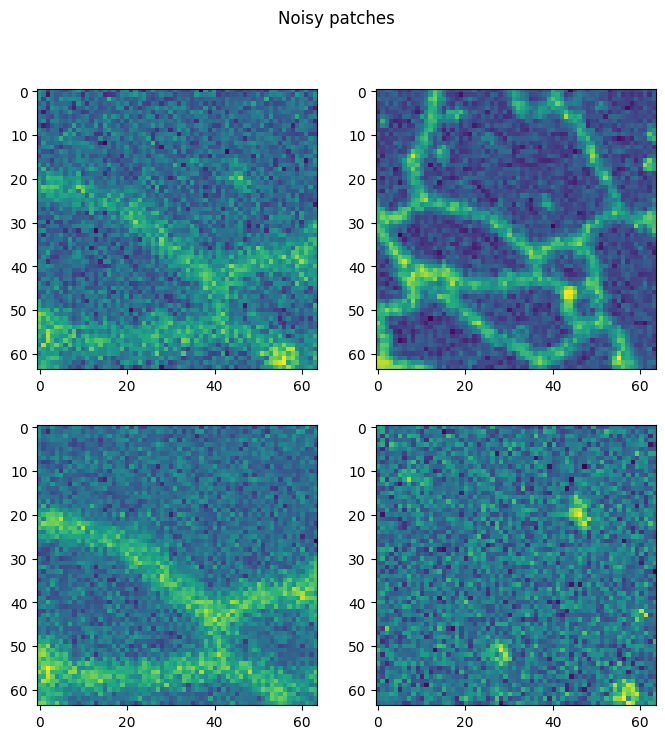

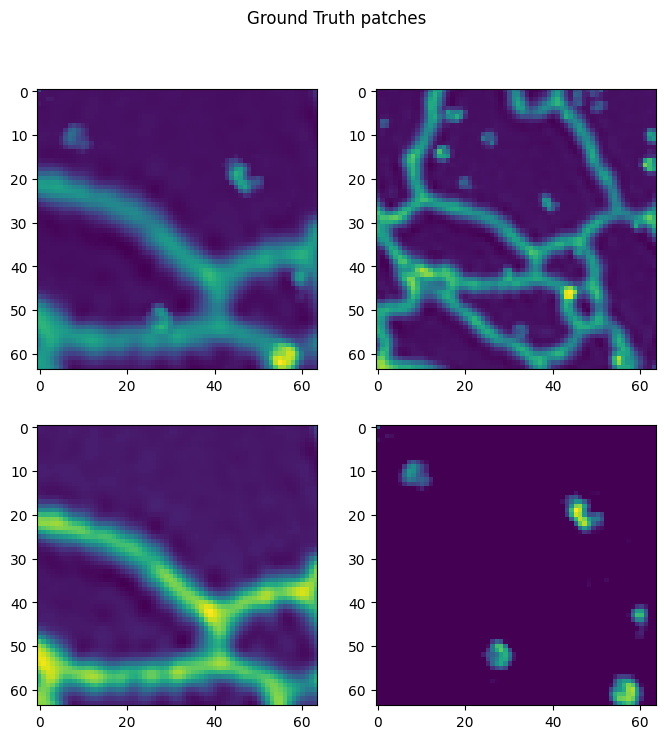

In [39]:
# Print input (first row) and target (second row) of the val_dset
idx = np.random.randint(len(val_dset))
inp_tmp, tar_tmp, *_ = val_dset[idx]
gt_inp_tmp, gt_tar_tmp, *_ = highsnr_val_dset[idx]

# Noisy
ncols = len(tar_tmp)
nrows = 2
_, ax = plt.subplots(figsize=(4*ncols,4*nrows), ncols=ncols, nrows=nrows)
plt.suptitle("Noisy patches")
for i in range(min(ncols, len(inp_tmp))):
    ax[0,i].imshow(inp_tmp[i])

for channel_id in range(ncols):
    ax[1,channel_id].imshow(tar_tmp[channel_id])

# Ground truth
ncols = len(gt_tar_tmp)
_, ax = plt.subplots(figsize=(4*ncols,4*nrows), ncols=ncols, nrows=nrows)
plt.suptitle("Ground Truth patches")
for i in range(min(ncols, len(gt_inp_tmp))):
    ax[0,i].imshow(gt_inp_tmp[i])

for channel_id in range(ncols):
    ax[1,channel_id].imshow(gt_tar_tmp[channel_id])

##### For debugging...

In [40]:
def get_full_input_frame(
    idx: int, dset: Union[MultiChDloader, LCMultiChDloader]
) -> tuple[torch.Tensor, int, int]:
    """Get the full input frame for a given index."""
    img_tuples, noise_tuples = dset._load_img(idx)
    if len(noise_tuples) > 0:
        factor = np.sqrt(2) if dset._input_is_sum else 1.0
        img_tuples = [x + noise_tuples[0] * factor for x in img_tuples]

    inp = 0
    for nch in img_tuples:
        inp += nch/len(img_tuples)
    h_start, w_start = dset._get_deterministic_hw(idx)
    return inp, h_start, w_start

In [41]:
# Select a subset of the data (e.g., for debugging)
if DEBUG and data_t_list is not None:
    val_dset.reduce_data(t_list=data_t_list)

In [42]:
if DEBUG:
    index = np.random.randint(len(val_dset))
    inp, tar = val_dset[index]
    frame, h_start, w_start = get_full_input_frame(index, val_dset)
    print(inp.shape, h_start, w_start)
    plt.imshow(inp[0])

In [43]:
# Plot predictions against a baseline for specific indexes
if DEBUG:
    def get_hwt_start(idx):
        h,w,t = val_dset.idx_manager.hwt_from_idx(idx, grid_size=64)
        print(h,w,t)
        pad = val_dset.per_side_overlap_pixelcount()
        h =  h - pad
        w = w - pad
        return h,w,t

    def get_crop_from_fulldset_prediction(full_dset_pred, idx, patch_size=256):
        h,w,t = get_hwt_start(idx)
        return np.swapaxes(full_dset_pred[t,h:h+patch_size,w:w+patch_size].astype(np.float32)[None], 0, 3)[...,0]

    if save_comparative_plots: # this is false...
        assert eval_datasplit_type == DataSplitType.Test
        # CCP vs Microtubules: 925, 659, 502
        # hdn_usplitdata = load_tiff('/group/jug/ashesh/data/paper_stats/Test_PNone_G16_M3_Sk0/pred_disentangle_2402_D23-M3-S0-L0_67.tif')
        hdn_usplitdata = load_tiff('/group/jug/ashesh/data/paper_stats/Test_PNone_G32_M5_Sk0/pred_disentangle_2403_D23-M3-S0-L0_29.tif')

        # ER vs Microtubule 853, 859, 332
        # hdn_usplitdata = load_tiff('/group/jug/ashesh/data/paper_stats/Test_PNone_G16_M3_Sk0/pred_disentangle_2402_D23-M3-S0-L0_60.tif')

        #  ER vs CCP 327, 479, 637, 568
        # hdn_usplitdata = load_tiff('/group/jug/ashesh/data/paper_stats/Test_PNone_G16_M3_Sk0/pred_disentangle_2402_D23-M3-S0-L0_59.tif')

        #  F-actin vs ER 797
        # hdn_usplitdata = load_tiff('/group/jug/ashesh/data/paper_stats/Test_PNone_G32_M10_Sk0/pred_disentangle_2403_D23-M3-S0-L0_15.tif')

        idx = 10 #np.random.randint(len(val_dset))
        patch_size = 500
        mmse_count = 50
        print(idx)
        show_for_one(
            idx, val_dset,
            highsnr_val_dset,
            model,
            None,
            mmse_count=mmse_count,
            patch_size=patch_size,
            baseline_preds=[
                get_crop_from_fulldset_prediction(hdn_usplitdata, idx).astype(np.float32),
            ],
            num_samples=0
        )

        plotsdir = get_plots_output_dir(
            ckpt_dir,
            patch_size,
            mmse_count=mmse_count
        )

        model_id = ckpt_dir.strip('/').split('/')[-1]
        fname = f'patch_comparison_{idx}_{model_id}.png'
        fpath = os.path.join(plotsdir, fname)
        plt.savefig(fpath, dpi=200, bbox_inches='tight')
        print(f'Saved to {fpath}')

#### Compute predictions and related metrics (PSNR) for the entire validation set

In [44]:
# NOTE: here, patch-wise PSNR is used, hence results are not trustworthy
pred_tiled, pred_std_tiled, logvar_tiled, rec_loss, patch_psnr_tuple,  = get_dset_predictions(
  model=light_model,
  dset=val_dset,
  batch_size=batch_size,
  num_workers=num_workers,
  mmse_count=mmse_count,
  loss_type=algo_config["loss"],
)
tmp = np.round([x.item() for x in patch_psnr_tuple], 2)
print(f"Patch wise PSNR, as computed during training {tmp}, avg: {np.mean(tmp)}")
print(f'Number of predicted tiles: {pred_tiled.shape[0]}, channels: {pred_tiled.shape[1]}, shape: {pred_tiled.shape[2:]}')
print(f'Reconstruction loss distrib: {np.quantile(rec_loss, [0,0.01,0.5, 0.9,0.99,0.999,1]).round(2)}')

Predicting patches: 100%|██████████| 36/36 [00:41<00:00,  1.16s/it]

Patch wise PSNR, as computed during training [29.71 29.84], avg: 29.775
Number of predicted tiles: 1125, channels: 2, shape: (64, 64)
Reconstruction loss distrib: [0.66 0.66 0.67 0.69 0.71 0.71 0.71]


In [ ]:
# Print tiles in which the logvar is very low
if DEBUG:
    idx_list = np.where(logvar_tiled.squeeze() < -6)[0]
    if len(idx_list) > 0:
        plt.imshow(val_dset[idx_list[0]][1][1])

Get full image predictions by stitching the predicted tiles

In [45]:
if pred_tiled.shape[-1] != val_dset.get_img_sz():
    pad = (val_dset.get_img_sz() - pred_tiled.shape[-1] )//2
    pred_tiled = np.pad(pred_tiled, ((0,0),(0,0),(pad,pad),(pad,pad)))

# Stitch tiled predictions
pred = stitch_predictions(
    pred_tiled,
    val_dset,
    smoothening_pixelcount=0
)

# # Stitch predicted tiled logvar
# if len(np.unique(logvar_tiled)) == 1:
#     logvar = None
# else:
#     logvar = stitch_predictions(logvar_tiled, val_dset, smoothening_pixelcount=0) # TODO: there's a bug here

# Stitch the std of the predictions (i.e., std computed on the mmse_count predictions)
pred_std = stitch_predictions(pred_std_tiled, val_dset, smoothening_pixelcount=0)

In [ ]:
if DEBUG:
    if 'target_idx_list' in data_config and data_config["target_idx_list"] is not None:
        pred = pred[...,:len(data_config["target_idx_list"])]
        pred_std = pred_std[...,:len(data_config["target_idx_list"])]

Ignore (and remove) the pixels which are present in the last few rows and columns (since not multiples of patch_size)
1. They don't come in the batches. So, in prediction, they are simply zeros. So they are being are ignored right now. 
2. For the border pixels which are on the top and the left, overlapping yields worse performance. This is becuase, there is nothing to overlap on one side. So, they are essentially zero padded. This makes the performance worse. 

In [46]:
def get_ignored_pixels():
    """Get the number of ignored pixels in the predictions.
    
    Given the current predictions `pred`, analyze the first image std
    to find the number of pixels that are ignored in prediction.
    """
    ignored_pixels = 1
    while(pred[0, -ignored_pixels:, -ignored_pixels:,].std() == 0):
        ignored_pixels+=1
    ignored_pixels-=1
    print(f'In {pred.shape}, last {ignored_pixels} many rows and columns are all zero.')
    return ignored_pixels

actual_ignored_pixels = get_ignored_pixels()
print(f'Actual ignored pixels: {actual_ignored_pixels}')

In (5, 1004, 1004, 2), last 44 many rows and columns are all zero.
Actual ignored pixels: 44


In [47]:
if data_config["data_type"] in [
    DataType.OptiMEM100_014,
    DataType.SemiSupBloodVesselsEMBL,
    DataType.Pavia2VanillaSplitting,
    DataType.ExpansionMicroscopyMitoTub,
    DataType.ShroffMitoEr,
    DataType.HTIba1Ki67
]:
    ignored_last_pixels = 32
elif data_config["data_type"] == DataType.BioSR_MRC:
    ignored_last_pixels = 44
elif data_config["data_type"] == DataType.NicolaData:
    ignored_last_pixels = 8
else:
    ignored_last_pixels = 0

ignore_first_pixels = 0
# assert actual_ignored_pixels <= ignored_last_pixels, f'Set ignored_last_pixels={actual_ignored_pixels}' # TODO: check this once stitching is fixed
print(ignored_last_pixels)

44


In [48]:
tar = val_dset._data
"""Data used to do evaluation againts. Shape is (N, H, W, C).

NOTE: this is the original data (`dset._data`), hence not normalized!
"""

if DEBUG:
    if 'target_idx_list' in data_config and data_config.target_idx_list is not None:
        tar = tar[..., data_config.target_idx_list]

def ignore_pixels(
    arr: Union[np.ndarray, torch.Tensor],
    patch_size: int
) -> Union[np.ndarray, torch.Tensor]:
    """Remove pixels that are ignored in the predictions."""
    if arr.shape[2] % patch_size:
        if ignore_first_pixels:
            arr = arr[:,ignore_first_pixels:,ignore_first_pixels:]
        if ignored_last_pixels:
            arr = arr[:,:-ignored_last_pixels,:-ignored_last_pixels]
    return arr

pred = ignore_pixels(pred, val_dset.get_img_sz())
tar = ignore_pixels(tar, val_dset.get_img_sz())
if pred_std is not None:
    pred_std = ignore_pixels(pred_std, val_dset.get_img_sz())

print(pred.shape)

(5, 960, 960, 2)


#### Perform Calibration

In [49]:
# TODO: not needed, target is already normalized
sep_mean = np.transpose(data_mean, axes=(0, 2, 3, 1))
sep_std = np.transpose(data_std, axes=(0, 2, 3, 1))

tar_normalized = (tar - sep_mean)/ sep_std

# Check if normalization is correct (i.e., not already applied on tar)
print(f"Channelwise means: tar -> {tar.mean(axis=(0,1,2))}, normalized -> {tar_normalized.mean(axis=(0,1,2))}")

Channelwise means: tar -> [6198.497  281.066], normalized -> [-0.00180865 -0.00698227]


Plot RMV vs. RMSE without Calibration

In [50]:
# NOTE: Recall the `pred_std` here is the pixel-wise std of the mmse_count many predictions
if enable_calibration:
    calib = Calibration(
        num_bins=30,
        mode='pixelwise'
    )
    native_stats = calib.compute_stats(
        pred=pred,
        pred_logvar=pred_std,
        target=tar_normalized
    )
    count = np.array(native_stats[0]['bin_count'])
    count = count / count.sum()
    # print(count.cumsum()[:-1])
    plt.plot(native_stats[0]['rmv'][1:-1], native_stats[0]['rmse'][1:-1], 'o')
    plt.title("RMV vs. RMSE plot - Not Calibrated")
    plt.xlabel('RMV'), plt.ylabel('RMSE')

Observe that the plot is far from resembling y = x!

In [ ]:
# def get_calibration_fnames(ckpt_dir):
#     tokens = ckpt_dir.strip('/').split('/')
#     modelid = int(tokens[-1])
#     model_specs = tokens[-2].replace('-','')
#     monthyear = tokens[-3]
#     fname_factor = f'calibration_factor_{monthyear}_{model_specs}_{modelid}.npy'
#     fname_stats = f'calibration_stats_{monthyear}_{model_specs}_{modelid}.pkl.npy'
#     return {'stats': fname_stats, 'factor': fname_factor}

# def get_calibration_factor_fname(ckpt_dir):
#     return get_calibration_fnames(ckpt_dir)['factor']

# def get_calibration_stats_fname(ckpt_dir):
#     return get_calibration_fnames(ckpt_dir)['stats']

In [51]:
if enable_calibration:
    inp, _ = val_dset[0]
    out_dir = get_eval_output_dir(ckpt_dir, inp.shape[1], mmse_count=mmse_count)
    fname = "calibration_factor.npy"
    factor_fpath = os.path.join(out_dir, fname)

    # Compute calibration factors
    if eval_datasplit_type == DataSplitType.Val:
        # Compute calibration factors for the channels
        calib_factors = []
        for i in range(pred.shape[-1]):
            calib_factors.append(
                get_calibrated_factor_for_stdev(
                    pred=pred[..., i],
                    pred_logvar=np.log(pred_std[..., i] ** 2),
                    target=tar_normalized[..., i],
                    batch_size=8,
                    lr=0.1
                )
            )
        print(f"Calibration factors: {[calib_factor for calib_factor in calib_factors]}")
        calib_factor = np.array(calib_factors).reshape(1, 1, 1, 2)
        np.save(factor_fpath, calib_factor)
        print(f'Saved calibration factor fitted on validation set to {factor_fpath}')

    # Use pre-computed calibration factor
    elif eval_datasplit_type == DataSplitType.Test:
        print('Loading the calibration factor from the file', factor_fpath)
        calib_factor = np.load(factor_fpath)

    # Given the calibration factor, plot RMV vs. RMSE
    calib = Calibration(num_bins=30, mode='pixelwise')
    pred_logvar = 2* np.log(pred_std * calib_factor)
    stats = calib.compute_stats(
        pred,
        pred_logvar,
        tar_normalized
    )
    _,ax = plt.subplots(figsize=(5,5))
    plt.title("RMV vs. RMSE plot - Calibrated")
    plot_calibration(ax, stats)

    if eval_datasplit_type == DataSplitType.Test:
        stats_fpath = os.path.join(out_dir, "calibration_stats.pkl.npy")
        np.save(stats_fpath, stats)
        print('Saved stats of Test set to ', stats_fpath)

A fancier Calibration Plot with multiple calibration factors:

In [52]:
def get_last_index(bin_count, quantile):
    cumsum = np.cumsum(bin_count)
    normalized_cumsum = cumsum / cumsum[-1]
    for i in range(1, len(normalized_cumsum)):
        if normalized_cumsum[-i] < quantile:
            return i - 1
    return None


def get_first_index(bin_count, quantile):
    cumsum = np.cumsum(bin_count)
    normalized_cumsum = cumsum / cumsum[-1]
    for i in range(len(normalized_cumsum)):
        if normalized_cumsum[i] > quantile:
            return i
    return None

In [53]:
# TODO: left for future refactoring
if enable_calibration:
    try:
        calib_factors = [
            np.load(os.path.join('/path/to/calibration/factors/dir/', fpath), allow_pickle=True)
            for fpath in [
                'calibration_stats_1.pkl.npy',
                'calibration_stats_2.pkl.npy',
                'calibration_stats_3.pkl.npy',
            ]
        ]
        labels = ['w=0.5', 'w=0.9', 'w=1']
    except FileNotFoundError:
        print('Calibration factors not found. Skipping the plot.')
        calib_factors = []

    if len(calib_factors) > 0:
        _,ax = plt.subplots(figsize=(5,2.5))
        for i, calibration_stats in enumerate(calib_factors):
            first_idx = get_first_index(calibration_stats[()][0]['bin_count'], 0.0001)
            last_idx = get_last_index(calibration_stats[()][0]['bin_count'], 0.9999)
            ax.plot(
                calibration_stats[()][0]['rmv'][first_idx:-last_idx],
                calibration_stats[()][0]['rmse'][first_idx:-last_idx],
                '-+',
                label=labels[i]
            )

        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')
        ax.plot(np.arange(0,1.5, 0.01), np.arange(0,1.5, 0.01), 'k--')
        ax.set_facecolor('xkcd:light grey')
        plt.legend(loc='lower right')
        # plt.xlim(0,3)
        # plt.ylim(0,1.25)
        plt.xlabel('RMV')
        plt.ylabel('RMSE')
        ax.set_axisbelow(True)


        plotsdir = get_plots_output_dir(ckpt_dir, 0, mmse_count=0)
        model_id = ckpt_dir.strip('/').split('/')[-1]
        fname = f'calibration_plot_{model_id}.png'
        fpath = os.path.join(plotsdir, fname)
        # plt.savefig(fpath, dpi=200, bbox_inches='tight')
        print(f'Saved to {fpath}')

#### Visually compare Targets and Predictions

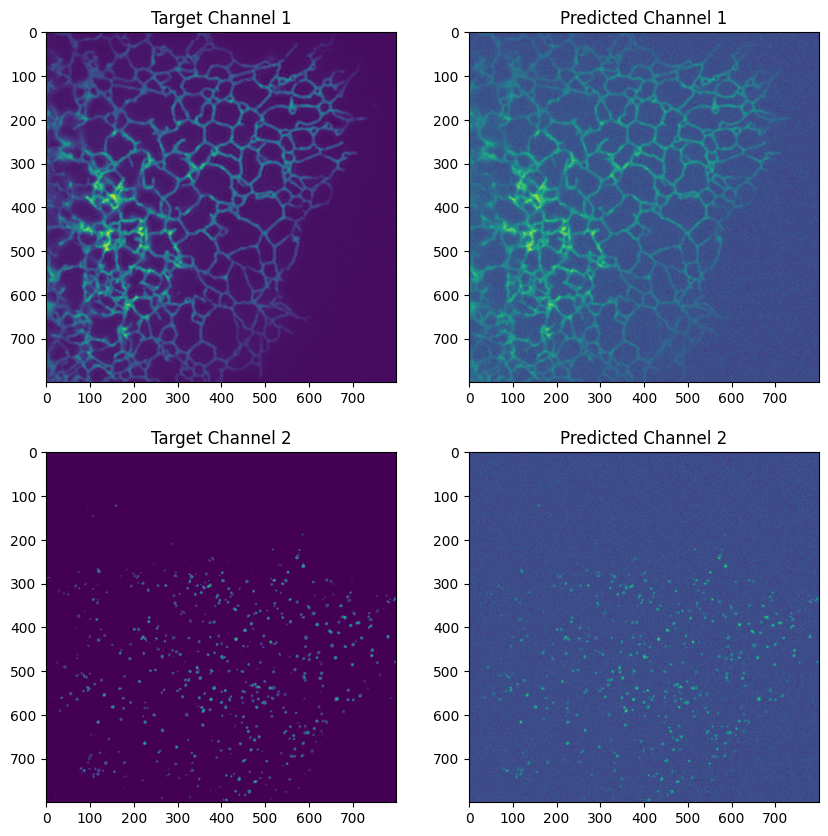

In [54]:
# One random target vs predicted image (patch of shape [sz x sz])
ncols = tar.shape[-1]
_,ax = plt.subplots(figsize=(ncols*5, 2*5), nrows=2, ncols=ncols)
img_idx = 0
sz = 800
hs = np.random.randint(tar.shape[1] - sz)
ws = np.random.randint(tar.shape[2] - sz)
for i in range(ncols):
    ax[i,0].set_title(f'Target Channel {i+1}')
    ax[i,0].imshow(tar[0, hs:hs+sz, ws:ws+sz, i])
    ax[i,1].set_title(f'Predicted Channel {i+1}')
    ax[i,1].imshow(pred[0, hs:hs+sz, ws:ws+sz, i])

# plt.subplots_adjust(wspace=0.1, hspace=0.1)
# clean_ax(ax)

4


/home/igor.zubarev/projects/caremics/src/careamics/lvae_training/eval_utils.py:423: UserWarning: Overwriting the cmap 'shiftedcmap' that was already in the registry.
  matplotlib.colormaps.register(cmap=newcmap, force=True)


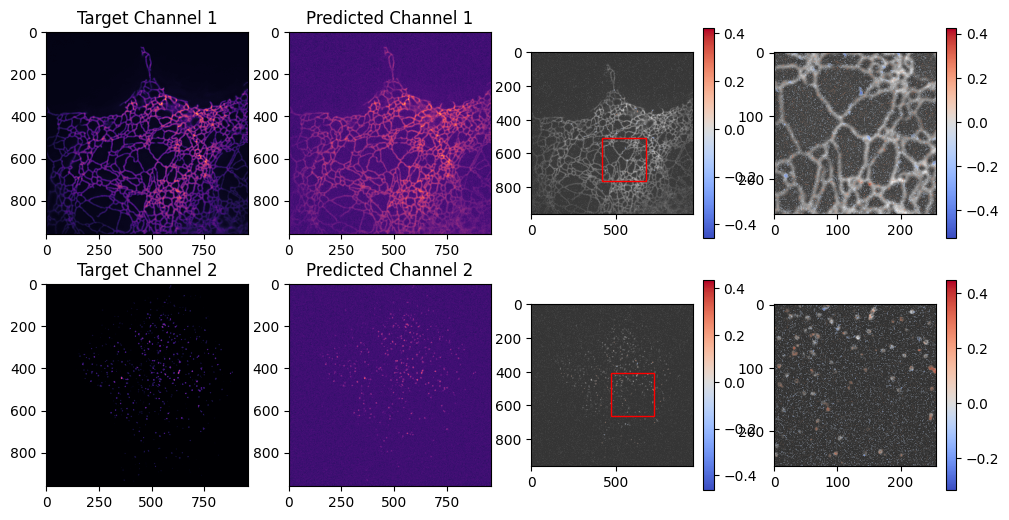

In [55]:
nrows = pred.shape[-1]
img_sz = 3
_,ax = plt.subplots(figsize=(4*img_sz,nrows*img_sz), ncols=4, nrows=nrows)
idx = np.random.randint(len(pred))
print(idx)
for ch_id in range(nrows):
    ax[ch_id,0].set_title(f'Target Channel {ch_id+1}')
    ax[ch_id,0].imshow(tar_normalized[idx,..., ch_id], cmap='magma')
    ax[ch_id,1].set_title(f'Predicted Channel {ch_id+1}')
    ax[ch_id,1].imshow(pred[idx,:,:,ch_id], cmap='magma')
    plot_error(
        tar_normalized[idx,...,ch_id],
        pred[idx,:,:,ch_id],
        cmap = matplotlib.cm.coolwarm,
        ax = ax[ch_id,2],
        max_val = None
    )

    cropsz = 256
    h_s = np.random.randint(0, tar_normalized.shape[1] - cropsz)
    h_e = h_s + cropsz
    w_s = np.random.randint(0, tar_normalized.shape[2] - cropsz)
    w_e = w_s + cropsz

    plot_error(
        tar_normalized[idx,h_s:h_e,w_s:w_e, ch_id],
        pred[idx,h_s:h_e,w_s:w_e,ch_id],
        cmap = matplotlib.cm.coolwarm,
        ax = ax[ch_id,3],
        max_val = None
    )

    # Add rectangle to the region
    rect = patches.Rectangle((w_s, h_s), w_e-w_s, h_e-h_s, linewidth=1, edgecolor='r', facecolor='none')
    ax[ch_id,2].add_patch(rect)


#### Compute metrics between predicted data and high-SNR (ground truth) data

Prepare data:

In [56]:
pred_unnorm = []
for i in range(pred.shape[-1]):
    if sep_std.shape[-1] == 1:
        temp_pred_unnorm = pred[...,i] * sep_std[...,0] + sep_mean[...,0]
    else:
        temp_pred_unnorm = pred[...,i] * sep_std[...,i] + sep_mean[...,i]
    pred_unnorm.append(temp_pred_unnorm)

In [57]:
# Get & process high-SNR data from previously loaded dataset
highres_data = highsnr_val_dset._data
if highres_data is not None:
    highres_data = ignore_pixels(highres_data, highsnr_val_dset.get_img_sz()).copy()
    if data_t_list is not None:
        highres_data = highres_data[data_t_list].copy()

    if "target_idx_list" in data_config and data_config["target_idx_list"] is not None:
        highres_data = highres_data[..., data_config["target_idx_list"]]

Compute metrics:

In [58]:
def avg_range_inv_psnr(
    pred: np.ndarray,
    target: np.ndarray,
) -> float:
    """Compute the average range-invariant PSNR."""
    psnr_arr = []
    for i in range(pred.shape[0]):
        psnr_arr.append(scale_invariant_psnr(pred[i], target[i]))
    return np.mean(psnr_arr)

In [59]:
if highres_data is not None:
    print(f'{DataSplitType.name(eval_datasplit_type)}_P{eval_patch_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignored_last_pixels}')
    psnr_list = [avg_range_inv_psnr(highres_data[...,k], pred_unnorm[k]) for k in range(len(pred_unnorm))]
    highres_norm = (highres_data - sep_mean) / sep_std
    # care_ssim_list = multiscale_ssim(highres_norm, pred)
    print(f"PSNR on Highres: {' '.join([str(x) for x in psnr_list])}, avg: {np.mean(psnr_list)}")
    # print(f"CARE-SSIM on Highres: {' '.join([str(np.round(x,3)) for x in care_ssim_list])}, avg: {np.mean(care_ssim_list)}")

Test_P64_G32_M10_Sk44
PSNR on Highres: 25.811175679576756 30.358834580404636, avg: 28.085005129990698


In [62]:
rmse_arr = []
psnr_arr = []
rinv_psnr_arr = []
ssim_arr = []
for ch_id in range(pred.shape[-1]):
    rmse =np.sqrt(((pred[...,ch_id] - tar_normalized[...,ch_id])**2).reshape(len(pred),-1).mean(axis=1))
    rmse_arr.append(rmse)
    # psnr = avg_psnr(tar_normalized[...,ch_id].copy(), pred[...,ch_id].copy())
    rinv_psnr = avg_range_inv_psnr(tar_normalized[...,ch_id].copy(), pred[...,ch_id].copy())
    # ssim_mean, ssim_std = avg_ssim(tar[...,ch_id], pred_unnorm[ch_id])
    # psnr_arr.append(psnr)
    rinv_psnr_arr.append(rinv_psnr)
    # ssim_arr.append((ssim_mean,ssim_std))

In [63]:
print(f'{DataSplitType.name(eval_datasplit_type)}_P{eval_patch_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignored_last_pixels}')
print('Rec Loss: ', np.round(rec_loss.mean(),3) )
print('RMSE: ', ' <--> '.join([str(np.mean(x).round(3)) for x in rmse_arr]))
print('PSNR: ', ' <--> '.join([str(x) for x in psnr_arr]))
print('RangeInvPSNR: ',' <--> '.join([str(x) for x in rinv_psnr_arr]))
print('SSIM: ',' <--> '.join([f'{round(x,3)}±{round(y,4)}' for (x,y) in ssim_arr]))
print()

Test_P64_G32_M10_Sk44
Rec Loss:  0.675
RMSE:  0.503 <--> 0.728
PSNR:  
RangeInvPSNR:  25.81117595984797 <--> 30.35883443634405
SSIM:  

